In [ ]:
# Command for Google Colab
# !gsutil -m cp -r "gs://butqdb-1.0.0.physionet.org" "."
# !mv "/content/butqdb-1.0.0.physionet.org" "/content/aura-data"
# !ln -s "/content/aura-data" "../aura-data"

In [ ]:
# Install package 
# !pip install scaleogram wfdb mat4py

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tensorflow import keras
import pywt
import scaleogram as scg 
from mat4py import loadmat
from scipy.fftpack import fft, ifft
import wfdb
import re
from math import *
#from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import time
import sys

# Read source for create a dataset of annotations
As inputs we have : 
- Signal frequence is 1000Hz so we have 1000 records per seconds
- 18 patients with 24H records per patient
- df_data : signal records data from .dat file (list of 90 millions records)
- df_annotation : labels quality class from .csv file (1, 2 or 3; 0 means the quality was not annotated in this segment) 
- Source : https://physionet.org/content/butqdb/1.0.0/

-> At first step, we will take we will take data only from the 111001 patient which seems to have the best balance of data in each class

## Analysis with patient 111001

- The signal frequence is 1000Hz, so we have 1000 records per seconds
- The average ECG period is 1 second
- We choice to split the dataset in records of 2 seconds partitions
- So the dataset will have 2000 features which is the value of the signal in period of 2 seconds
- The 2001th feature of our dataset will be the label of our signal (value extract from the final label feature in the annotation file)
- In order to low the data loaded in RAM and speed the model training, we will reduce the signal length frequence from 1000Hz to 250Hz (so to take one 1 in 8 in our 2 seconds period, we will check after if this method doesn't bias the model training)

In [2]:
# See annotation file for patient 111001
# For now, we just considere the 3 last columns : 
#   - the start and end columns which is the interval (in ms) in which the signal was labelized
#   - the class which is the signal label
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
df_csv = pd.read_csv("../aura-data/111001/111001_ANN.csv", names=header_list)
df_csv = df_csv[df_csv["class"].notnull() & df_csv["start"].notnull() & df_csv["end"].notnull()]
df_csv.head()


,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class
0,1.0,4315694.0,2.0,1.0,411254.0,2.0,1,7523,1,1.0,415143.0,2.0
1,4315695.0,4334794.0,1.0,411255.0,421291.0,1.0,7524,16977,2,415144.0,421291.0,1.0
2,4334795.0,7908996.0,2.0,421292.0,433271.0,2.0,16978,18848,1,421292.0,433515.0,2.0
3,7908997.0,7915643.0,1.0,433272.0,447315.0,1.0,18849,105566,2,433516.0,447315.0,1.0
4,7915644.0,13719093.0,2.0,447316.0,451027.0,2.0,105567,108563,1,447316.0,451027.0,2.0


In [3]:
# Create list with class label for each range of 2000 records
alist=[]
for i in range(0,len(df_csv)):
    if int(df_csv.end[i]) > len(alist)*2000:
        #print(i)
        for ii in range(0, (int(df_csv.end[i])-len(alist)*2000)//2000):
            alist.append(df_csv["class"][i])

In [4]:
# Have a look of the balance of values for each class
pd.DataFrame(alist).value_counts()

2.0    24308
1.0    19011
3.0     2003
dtype: int64

In [5]:
# Import records and reshape it to array matrix with 2000 features 
# Import all data in array
arr_data_2000 = wfdb.rdrecord("../aura-data/111001/111001_ECG")
arr_data_2000 = arr_data_2000.adc()
arr_data_2000.shape

(90645000, 1)

In [109]:
arr_data_2000[:2000][-5:]

array([[13574],
       [13569],
       [13571],
       [13584],
       [13604]])

In [6]:
# Reshape vector data into a Matrix
# We need to crop our array data to 90644000 in order it can be divided by 2000 and reshape function works
arr_data_2000 = arr_data_2000[:90644000].reshape(arr_data_2000[:90644000].shape[0]//2000,2000)

In [9]:
arr_data_2000.shape

(45322, 2000)

In [10]:
arr_data_2000[0][-5:]

array([13574, 13569, 13571, 13584, 13604])

In [7]:
# Concatenate data array matrix with label column vector array
arr_data_2000 = np.concatenate((arr_data_2000,np.array(alist).reshape(len(alist),1)), axis=1)


In [12]:
arr_data_2000.shape

(45322, 2001)

In [8]:
# Order the array by class 
# Create a dataframe pandas from data numpy array
df_data_2000 = pd.DataFrame(arr_data_2000)
df_data_2000.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,21753.0,21748.0,21770.0,21788.0,21789.0,21799.0,21793.0,21783.0,21789.0,21791.0,21775.0,21740.0,21724.0,21698.0,21672.0,21674.0,21671.0,21668.0,21667.0,21660.0,21650.0,21659.0,21662.0,21662.0,21678.0,...,13677.0,13683.0,13677.0,13662.0,13669.0,13655.0,13644.0,13653.0,13654.0,13657.0,13653.0,13634.0,13628.0,13640.0,13627.0,13593.0,13582.0,13593.0,13590.0,13574.0,13569.0,13571.0,13584.0,13604.0,2.0
1,13610.0,13594.0,13592.0,13594.0,13609.0,13628.0,13620.0,13600.0,13597.0,13586.0,13565.0,13555.0,13553.0,13543.0,13532.0,13530.0,13521.0,13511.0,13511.0,13515.0,13509.0,13499.0,13519.0,13533.0,13534.0,...,8048.0,8041.0,8032.0,8032.0,8030.0,8014.0,8005.0,8009.0,8018.0,8007.0,7987.0,7982.0,7983.0,7996.0,7994.0,7997.0,7997.0,7992.0,8000.0,8009.0,8001.0,7996.0,7993.0,7986.0,2.0
2,7989.0,7982.0,7984.0,8008.0,8030.0,8039.0,8049.0,8034.0,8017.0,8021.0,8021.0,8014.0,8015.0,8013.0,8010.0,8019.0,8025.0,8030.0,8041.0,8042.0,8026.0,8022.0,8037.0,8027.0,8012.0,...,4880.0,4892.0,4891.0,4891.0,4876.0,4856.0,4852.0,4869.0,4884.0,4890.0,4868.0,4838.0,4833.0,4832.0,4828.0,4840.0,4866.0,4874.0,4864.0,4868.0,4881.0,4873.0,4866.0,4866.0,2.0
3,4863.0,4860.0,4852.0,4844.0,4842.0,4846.0,4851.0,4851.0,4846.0,4832.0,4823.0,4830.0,4837.0,4833.0,4829.0,4838.0,4853.0,4849.0,4840.0,4831.0,4826.0,4836.0,4852.0,4856.0,4843.0,...,2803.0,2802.0,2806.0,2818.0,2810.0,2804.0,2800.0,2795.0,2799.0,2807.0,2815.0,2810.0,2800.0,2788.0,2774.0,2764.0,2756.0,2748.0,2752.0,2752.0,2744.0,2740.0,2732.0,2723.0,2.0
4,2715.0,2720.0,2721.0,2725.0,2736.0,2743.0,2741.0,2728.0,2720.0,2706.0,2684.0,2651.0,2611.0,2589.0,2596.0,2619.0,2650.0,2684.0,2712.0,2735.0,2753.0,2765.0,2786.0,2792.0,2785.0,...,2059.0,2082.0,2091.0,2078.0,2063.0,2065.0,2060.0,2041.0,2025.0,1989.0,1950.0,1904.0,1871.0,1860.0,1860.0,1868.0,1870.0,1872.0,1884.0,1882.0,1854.0,1822.0,1809.0,1792.0,2.0


In [9]:
# Order dataframe by columns and transform it to np array
arr_data_2000 = df_data_2000.sort_values(by=[2000]).values
arr_data_2000.shape

(45322, 2001)

In [612]:
# Store dataframe in CSV file
# df_data_labels.to_csv("data_111001.csv")

In [10]:
# We filter 19011 first datas labelized class 1
arr_class_1 = arr_data_2000[:19011][:,:2000][:,:2000:8] # take 1 point on 8 to reduce frequency : from 1000Hz to 125Hz and optimised the data
arr_class_1 = arr_class_1/1000 # normalize data to reduce dispersion
arr_class_1

array([[-0.159, -0.167, -0.172, ...,  0.005,  0.003, -0.006],
       [-0.055, -0.059, -0.077, ..., -0.048, -0.043, -0.046],
       [-0.338, -0.334, -0.334, ..., -0.437, -0.436, -0.441],
       ...,
       [-0.166, -0.164, -0.16 , ...,  0.337,  0.344,  0.359],
       [ 0.084,  0.107,  0.11 , ..., -0.071, -0.072, -0.075],
       [ 0.388,  0.373,  0.379, ...,  0.201,  0.191,  0.185]])

In [11]:
arr_class_1.shape

(19011, 250)

In [12]:
# We filter 19011 first datas labelized class 2
arr_class_2 = arr_data_2000[19011:19011+24308][:,:2000][:,:2000:8]
arr_class_2 = arr_class_2/1000
arr_class_2

array([[-4.450e-01, -4.120e-01, -3.770e-01, ...,  6.000e-02, -4.250e-01,
        -7.030e-01],
       [-3.530e-01, -3.310e-01, -3.000e-02, ..., -1.960e-01, -4.330e-01,
        -3.330e-01],
       [-4.000e-02, -6.700e-02, -6.900e-02, ...,  1.400e-02, -1.500e-02,
         1.000e-03],
       ...,
       [ 1.260e-01,  1.270e-01,  1.200e-01, ..., -5.060e-01, -5.060e-01,
        -5.110e-01],
       [ 1.351e+00,  1.345e+00,  1.344e+00, ...,  3.740e-01,  2.990e-01,
         2.650e-01],
       [ 1.780e-01,  1.600e-01,  1.360e-01, ...,  2.570e-01,  2.550e-01,
         2.330e-01]])

In [13]:
arr_class_3 = arr_data_2000[19011+24308:19011+24308+2003][:,:2000][:,:2000:8]
arr_class_3 = arr_class_3/1000
arr_class_3

array([[ 0.179,  0.186,  0.195, ..., -1.887, -1.359,  0.265],
       [-1.402, -1.42 , -1.634, ..., -1.745, -1.806, -1.905],
       [-0.361, -0.362, -0.366, ..., -0.044, -0.402, -0.648],
       ...,
       [ 0.024,  0.042,  0.049, ..., -0.041, -0.049, -0.01 ],
       [ 0.129,  0.027, -0.068, ..., -0.257, -0.26 , -0.253],
       [-0.121, -0.096, -0.095, ...,  0.087,  0.077,  0.071]])

## Analysis Wavelet Transformation & Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


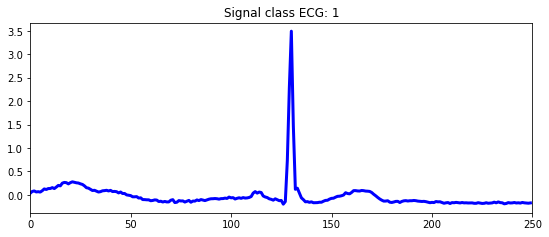

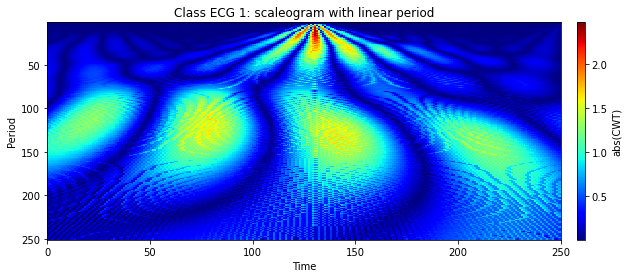

In [24]:
# Display Scaleogram of signal labelled in class 1
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = np.random.randint(0,len(arr_class_1))
data = arr_class_1[nn]
label = 1

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")
    

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


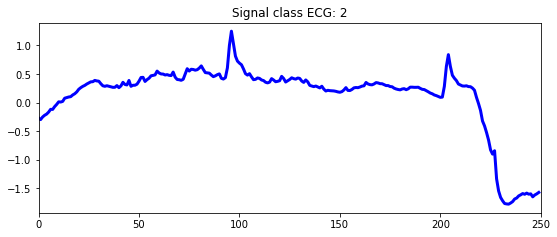

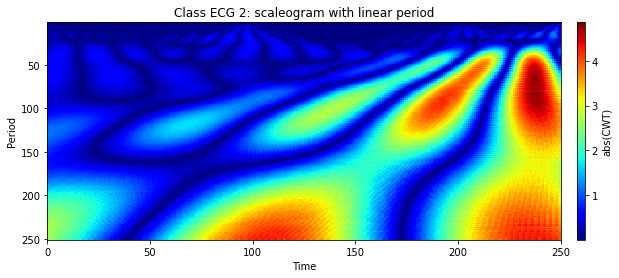

In [21]:
# Display Scaleogram of signal labelled in class 2
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = np.random.randint(0,len(arr_class_2))
data = arr_class_2[nn]
label = 2

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


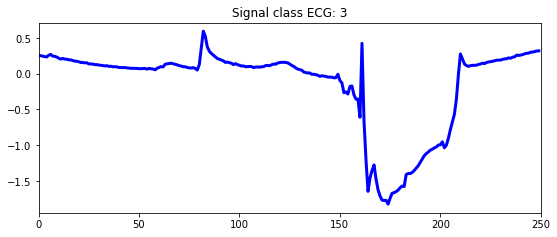

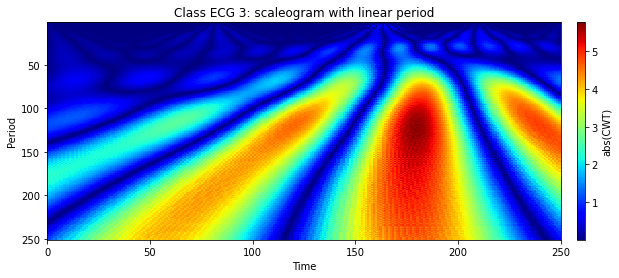

In [23]:
# Display Scaleogram of signal labelled in class 3
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = np.random.randint(0,len(arr_class_3))
data = arr_class_3[nn]
label = 3

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

# Create model classification prediction

## 1- Train & test NN model

In [25]:
# Convert array into list to train our model
arr_class_1_flatten = list(arr_class_1)
arr_class_2_flatten = list(arr_class_2)
arr_class_3_flatten = list(arr_class_3)

In [64]:
len(arr_class_1_flatten), len(arr_class_1_flatten[0])

(19011, 250)

In [65]:
len(arr_class_1_flatten), len(arr_class_2_flatten), len(arr_class_3_flatten)

In [26]:
# Reduce samples data for each class to reduce_size
reduce_size = 1000
full_1500 = (arr_class_1_flatten[0:reduce_size] + arr_class_2_flatten[0:reduce_size] + arr_class_3_flatten[0:reduce_size])


In [27]:
# create the data set with scaleogramme image for each signal data
# We create a X_full 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

start_time = time.time()

fs = len(full_1500[0])
# sgn_length = 1000   #65536   Pay atention with ram memory! 
size_dataset = len(full_1500)
scales = range(1, fs)
waveletname = 'morl'
 
X_full = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))
                 
for i in tqdm(range(0, size_dataset)):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_1500[i]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        X_full[i, :, :, j] = coeff[:,:fs-1]

end_time = time.time()

print(f"Time spent : {end_time - start_time} seconds")

0 done!
500 done!
1000 done!
1500 done!
2000 done!
2500 done!

Time spent : 382.56850004196167 seconds


In [40]:
X_full.shape

(3000, 249, 249, 3)

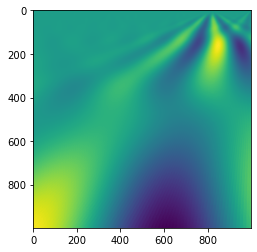

In [91]:
plt.imshow(X_full[0, :, :, 0])

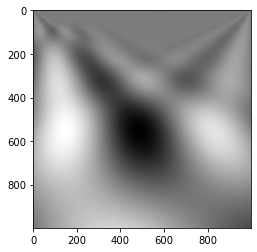

In [134]:
plt.imshow(X_full[1, :, :, 0], cmap="gray")

In [29]:
# Create label encoder
list_labels_class_1 = ['1']*reduce_size 
list_labels_class_2 = ['2']*reduce_size 
list_labels_class_3 = ['3']*reduce_size 
list_labels = (list_labels_class_1 + list_labels_class_2 + list_labels_class_3)

le = preprocessing.LabelEncoder()
list_labels_encoded = le.fit_transform(list_labels)
X_train, X_test, y_train, y_test = train_test_split(X_full, list_labels_encoded, test_size=0.25, random_state=42)


In [257]:
list_labels_encoded

array([0, 0, 0, ..., 2, 2, 2])

In [42]:
X_train.shape

(2250, 249, 249, 3)

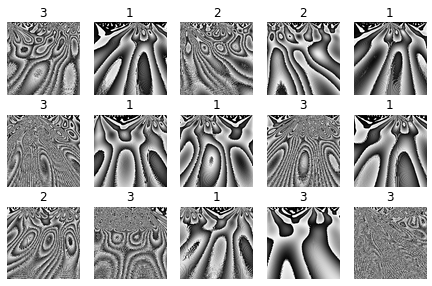

In [30]:
#Inspecting DATA that we will give as input for the model
n_rows = 3
n_cols = 5
class_names = ['1', '2', '3']
plt.figure(figsize=(n_cols*1.5, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_train[index]*255).astype(np.uint8), cmap="binary", interpolation="spline36")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

In [34]:
# Defining basic NN
num_filter, num_classes = 3, 3
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fs-1, fs-1, num_filter]),
    keras.layers.Dense(1024, activation="relu"),
    #keras.layers.Dense(600, activation="relu"),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dense(300, activation="relu"),                 
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam", metrics=["accuracy"])

In [35]:
# Display model layers and neurones for each layer
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 186003)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1028)              191212112 
_________________________________________________________________
dense_4 (Dense)              (None, 512)               526848    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 191,923,263
Trainable params: 191,923,263
Non-trainable params: 0
________________________________________

In [36]:
# Train the model with training and validation data - first try
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
71/71 [==============================] - 66s 935ms/step - loss: 74.4632 - accuracy: 0.3920 - val_loss: 41.1223 - val_accuracy: 0.4147
Epoch 2/30
71/71 [==============================] - 59s 824ms/step - loss: 39.3097 - accuracy: 0.3991 - val_loss: 17.1012 - val_accuracy: 0.4053
Epoch 3/30
71/71 [==============================] - 79s 1s/step - loss: 12.0968 - accuracy: 0.4498 - val_loss: 7.7492 - val_accuracy: 0.4507
Epoch 4/30
71/71 [==============================] - 75s 1s/step - loss: 4.9943 - accuracy: 0.4538 - val_loss: 3.3886 - val_accuracy: 0.5187
Epoch 5/30
71/71 [==============================] - 73s 1s/step - loss: 2.5573 - accuracy: 0.4982 - val_loss: 2.4018 - val_accuracy: 0.4680
Epoch 6/30
71/71 [==============================] - 71s 995ms/step - loss: 1.7276 - accuracy: 0.5342 - val_loss: 1.5792 - val_accuracy: 0.5267
Epoch 7/30
71/71 [==============================] - 71s 994ms/step - loss: 3.4350 - accuracy: 0.5387 - val_loss: 3.6652 - val_accuracy: 0.4853
Epo

In [40]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 8s 348ms/step - loss: 0.8112 - accuracy: 0.6667


[0.81119704246521, 0.6666666865348816]

In [37]:
# model.save('modele_NN') # save modele

In [38]:
# model = keras.models.load_model('modele_NN') # load model 

In [39]:
# Train the model with training and validation data - Second try (after model saved after 20 epochs)
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


In [41]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', size = 16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('Figure_epochs.png')   
    plt.close()

In [42]:
plot_learning_curves(history)

In [43]:
prediction = model.predict(X_test)
pred_classes = prediction.argmax(axis=1)

In [44]:
# Confusion Matrix With Scikit
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_classes)
cm_norm =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Text(189.2400000000001, 0.5, 'True')

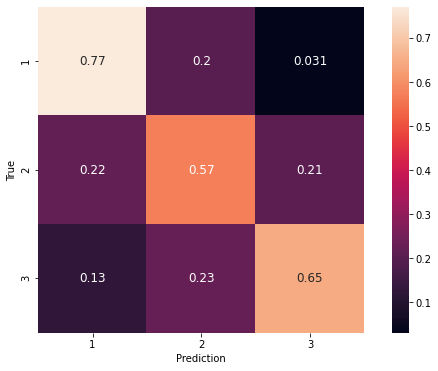

In [45]:
# Ploting Confusion Matrix

df_cm = pd.DataFrame(cm_norm, ['1', '2', '3'], ['1', '2', '3'])
plt.figure(figsize = (10,6))
conf = sns.heatmap(df_cm, annot=True, square=True, annot_kws={"size": 12})
conf.set_xlabel('Prediction')
conf.set_ylabel('True')

## 2- Train & test CNN model

In [51]:
#!pip install tensorflow
import tensorflow as tf 
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [47]:
le = preprocessing.LabelEncoder()
list_labels_encoded = le.fit_transform(list_labels)
X_train, X_test, y_train, y_test = train_test_split(X_full, list_labels_encoded, test_size=0.25, random_state=42)

In [52]:
# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[249, 249, 3]), #-> output matrix 249 x 249 x 3
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"), #-> output matrix 16 x 16 x 32
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"), #-> output matrix 8 x 8 x 64
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Flatten(), # -> 1024
    tf.keras.layers.Dense(units=64, activation='relu'), #-> 64
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=32, activation ="relu"), #-> 32
    tf.keras.layers.Dense(units=16, activation ="relu"), #-> 16
    tf.keras.layers.Dense(units=3, activation='softmax') #-> 3
])

In [53]:
# Create a schedule learning rate
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

In [54]:
# Create a compiler
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError)
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 249, 249, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 61504)            

In [56]:
# Train the model with training and validation data - first try
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - 175s 2s/step - loss: 1.0175 - sparse_categorical_accuracy: 0.3613 - val_loss: 0.9681 - val_sparse_categorical_accuracy: 0.5053
Epoch 2/30
71/71 [==============================] - 160s 2s/step - loss: 0.8894 - sparse_categorical_accuracy: 0.5542 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.7267
Epoch 3/30
71/71 [==============================] - 151s 2s/step - loss: 0.7686 - sparse_categorical_accuracy: 0.6987 - val_loss: 0.6581 - val_sparse_categorical_accuracy: 0.7360
Epoch 4/30
71/71 [==============================] - 153s 2s/step - loss: 0.6896 - sparse_categorical_accuracy: 0.7218 - val_loss: 0.5881 - val_sparse_categorical_accuracy: 0.7693
Epoch 5/30
71/71 [==============================] - 163s 2s/step - loss: 0.6294 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.5654 - val_sparse_categorical_accuracy: 0.7800
Epoch 6/30
71/71 [==============================] - 133s 2s/step - loss: 0.5814 - sparse_categorical_accu

In [57]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 7s 288ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8560


[0.35964855551719666, 0.8560000061988831]

In [61]:
model.history.history

{}

In [59]:
loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]
plt.plot(loss)
plt.plot(val_loss)

KeyError: 'loss'

In [41]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', size = 16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('Figure_epochs.png')   
    plt.close()

In [62]:
plot_learning_curves(history)

In [63]:
prediction = model.predict(X_test)
pred_classes = prediction.argmax(axis=1)

In [64]:
# Confusion Matrix With Scikit
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_classes)
cm_norm =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Text(189.2400000000001, 0.5, 'True')

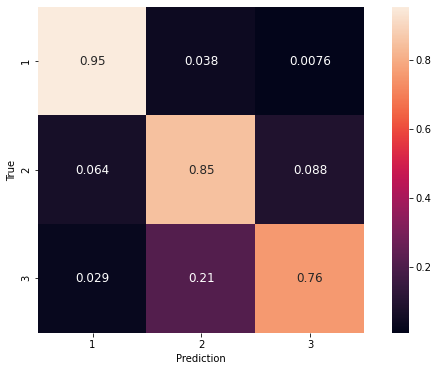

In [65]:
# Ploting Confusion Matrix

df_cm = pd.DataFrame(cm_norm, ['1', '2', '3'], ['1', '2', '3'])
plt.figure(figsize = (10,6))
conf = sns.heatmap(df_cm, annot=True, square=True, annot_kws={"size": 12})
conf.set_xlabel('Prediction')
conf.set_ylabel('True')

In [71]:
# Save trained CNN model
model.save("CNN_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: CNN_model/assets


## 3- Test the CNN model with data production

In [ ]:
# Reconstruct my CNN model
# reconstructed_model = keras.models.load_model("CNN_model")

In [91]:
# Create reduced samples data for each class to production_size for production
production_size = 100
full_prod = (arr_class_1_flatten[reduce_size:reduce_size+production_size] + arr_class_2_flatten[reduce_size:reduce_size+production_size] + arr_class_3_flatten[reduce_size:reduce_size+production_size])


In [92]:
# Test with production values : create X_prod as input production datas
fs = len(full_prod[0])
# sgn_length = 1000   #65536   Pay atention with ram memory! 
size_dataset = len(full_prod)
scales = range(1, fs)
waveletname = 'morl'
 
X_prod = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))
                 
for i in tqdm(range(0, size_dataset)):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_prod[i]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        X_prod[i, :, :, j] = coeff[:,:fs-1]

0 done!



In [85]:
# Test model usage for classification prediction in production
# model.predict_classes(X_prod)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 0, 1, 1, 2])

In [93]:
# Create label encoder for production tests
list_labels_class_1_prod = ['1']*production_size 
list_labels_class_2_prod = ['2']*production_size 
list_labels_class_3_prod = ['3']*production_size 
list_labels_prod = (list_labels_class_1_prod + list_labels_class_2_prod + list_labels_class_3_prod)

le = preprocessing.LabelEncoder()
list_labels_encoded_prod = le.fit_transform(list_labels_prod)

In [94]:
model.evaluate(X_prod, list_labels_encoded_prod)

10/10 [==============================] - 3s 253ms/step - loss: 0.1958 - sparse_categorical_accuracy: 0.9200


[0.19581255316734314, 0.9200000166893005]